Major League Baseball Team Stats' Relative Importance
=========
-----

I am a huge baseball fan. I usually check the scores and stats for my favorite teams after each game. Watching the games is very <BR>much enjoyable itself but I often imagine myself being a general menager building and leading mlb team. One of the most important <BR>responsibilities of a general menager's responsibility is to find a way to imporve his team to win more games unless his team is in a <BR>"rebuilding period". But sometimes it is not easy to pinpoint the team's weaknesses. Also, there are too many different statistics <BR>available these days to evaluate the team's performance. Even if he already knows in which areas his team needs improvement, <BR>he still has to find the most efficient way to cover those areas. For example, let's say that the team needs to hit more home runs and <BR>walk more, but the GM does not have options that would upgrade his team in both stats. How would he make the decision? Which one <BR>of those two stats would have more effect on the team?

So I thought it would be interesting to build linear regression models predicting team's winning percentage from team stats and <BR>compare the "importance" of each stat by its coefficient, since regression coefficients represent the mean change in the response <BR>variable(team's winning percentage) for one unit of change in the predictor variable(team stat) while holding other predictors in the <BR> model constant. The model can be also useful to determine which player is, and/or would be more helpful to the team.

I used the csv file downloaded from [seanlahman.com](http://www.seanlahman.com/baseball-archive/statistics/). The latest version of the database as of 10/05/2016 contained complete batting<BR> and pitching  statistics from 1871 to 2015, plus fielding statistics, standings, team stats, managerial records, post-season data, and<BR> more. However, some statistics(WAR, ERA+, WHIP, OPS, UZR, ...) were excluded from the database for team stats. 

* Python modules : **scikit-learn, pandas, numpy**
* machine learning : **linear regression (Ordinary Least Squares, Ridge, and Lasso)**

In [1]:
import pandas as pd
import numpy as np
from pylab import *

from sklearn import linear_model
from sklearn import metrics
from sklearn import cross_validation

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category = Warning)

pd.set_option('display.max_colwidth', -1)

We Define the file path and import the data into Pandas data frame.
---
The data is for teams from 1871 to 2015. The documentation for the data can be found [here](http://seanlahman.com/files/database/readme2014.txt).<BR>


In [2]:
file_path = 'C:\\Users\\Young Wook\\Desktop\\stuffs\\DS\\projects\\mlb\\teams.csv'
df_all = pd.read_csv(file_path, sep = ',')

In [3]:
df_all.shape

(2805, 48)

Let's look at some of the data.
---
There are 2805 rows/teams and 48 columns/stats in total.

In [4]:
df_all.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,NaN,0.83,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,NaN,0.82,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,NaN,0.81,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,NaN,0.80,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,NaN,0.83,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


### The following are the descriptions of the columns/stats.

**yearID:** *year*&emsp; **lgID:** *league*&emsp; **teamID:** *team*&emsp; **franchID:** *franchise*&emsp; **divID:** *team's division*&emsp; **Rank:** *osition in final standings*   
**G:** *games played*&emsp; **Ghome:** *games played at home*&emsp; **W:** *wins*&emsp; **L:** *losses*&emsp; **DivWin:** *division winner(Y, N)*   
**WCWin:** *wild card winner(Y, N)*&emsp; **LgWin:** *league champion(Y, N)*&emsp; **WSWin:** *world series winner (Y, N)*&emsp; **R:** *runs scored*   
**AB:** *at bats*&emsp; **H:** *hits by batters*&emsp; **2B:** *doubles*&emsp; **3B:** *triples*&emsp; **HR:** *homeruns by batters*&emsp; **BB:** *walks by batters*   
**SO:** *strikeouts by batters*&emsp; **SB:** *stolen bases*&emsp;	**CS:** *caught stealing*&emsp;	**HBP:** *batters hit by pitch*&emsp; **SF:** *sacrifice flies*      
**RA:** *opponents runs scored*&emsp; **ER:** *earned runs allowed*&emsp; **ERA:** *earned run average*&emsp; **CG:** *complete games*&emsp; **SHO:** *shutouts*   
**SV:** *saves*&emsp; **IPouts:** *outs pitched*&emsp; **HA:** *hits allowed*&emsp; **HRA:** *homeruns allowed*&emsp; **BBA:** *walks allowed*   
**SOA:** *strikeouts by pitchers*&emsp; **E:** *errors*&emsp; **DP:** *double plays*&emsp; **FP:** *fielding percentage*&emsp; **name:** *team's full name*   
**park:** *name of team's home ballpark*&emsp; **attendance:** *home attendance total*&emsp; **BPF:** *three-year park factor for batters*   
**PPF:** *three-year park factor for pitchers*&emsp;
**teamIDBR:** *team ID used by Baseball Reference website*		
**teamIDlahman45:** *team ID used in Lahan database version 4.5*&emsp; **teamIDretro:**	*team ID used by Retrosheet*   

* More than half of the columns are either redundant(L, AB, ...) or not suitable for analysis(yearID, teamID, ...).   
* So we create a list containing all the columns to be removed and drop them from the dataframe.  
* Also, there are some missing values (NaN = 'Not a Number') so we drop the rows containing them.

In [5]:
remove_list = ['yearID','lgID','teamID','franchID','divID','Rank','Ghome','L','DivWin','WCWin',
               'LgWin','WSWin','AB','SB','CS','HBP','SF','ER','CG','SV','IPouts','name','park',
               'attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro']

In [6]:
df_all.drop(remove_list, inplace = True, axis = 1)

In [7]:
df = df_all.dropna(how = 'any')

In [8]:
df.head()

,G,W,R,H,2B,3B,HR,BB,SO,RA,ERA,SHO,HA,HRA,BBA,SOA,E,DP,FP
50,70,39,471,723,96,24,9,58,98,450,2.51,3,732,7,104,77,422,42,0.86
51,66,52,624,926,131,32,8,70,45,257,1.76,9,608,6,29,51,282,33,0.89
52,65,9,238,555,51,12,4,41,136,579,3.62,0,850,9,34,60,469,45,0.84
53,69,47,429,711,96,22,2,39,78,261,1.67,11,570,2,27,114,337,27,0.88
54,69,30,280,641,68,14,6,24,98,344,1.69,5,605,3,38,125,396,44,0.87


Now,
---
To compare the values of each team, we have to divide every column with 'G' except for 'ERA' and 'FP'  
(Values of 'ERA' and 'FP' are already pre-adjusted by definition)   
To avoid the int division, we need to make sure that the dtype of 'G' column is 'float64'.  Then, we do the division.

In [9]:
df['G'].dtype

dtype('int64')

In [10]:
df['G'] = df['G'].astype('float64')

In [11]:
columns = list(df.columns)
for i in ['G','ERA','FP']:
    columns.remove(i)
print columns

['W', 'R', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'RA', 'SHO', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP']


In [12]:
for col in columns:
    df[col] = df[col] / df['G']

### We define response and features. 

In [13]:
response = 'W'
games_played = 'G'
features = list(df.columns)
features.remove(response)
features.remove(games_played)

In [14]:
print len(features), 'features:', features
print ' 1 response:', response

17 features: ['R', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'RA', 'ERA', 'SHO', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP']
 1 response: W


We have 17 features.

### Let's look at a quick statistic summary of our data.

In [15]:
df.describe()

,G,W,R,H,2B,3B,HR,BB,SO,RA,ERA,SHO,HA,HRA,BBA,SOA,E,DP,FP
count,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000
mean,155.052365,0.497937,4.450727,8.958419,1.548515,0.286389,0.729902,3.191030,5.038122,4.451812,3.879789,0.064436,8.958730,0.729961,3.190746,5.038053,1.034898,0.915181,0.970372
std,15.594994,0.081935,0.660820,0.675121,0.269378,0.134666,0.342626,0.612544,1.542178,0.680471,0.685601,0.030337,0.706845,0.315503,0.607341,1.554158,0.713335,0.144458,0.016560
min,57.000000,0.138462,2.609272,6.932927,0.684211,0.067901,0.000000,0.315789,0.600000,2.792208,1.220000,0.000000,6.709877,0.023256,0.391304,0.366667,0.333333,0.315789,0.820000
25%,154.000000,0.444444,4.000000,8.500000,1.349367,0.188109,0.490196,2.870968,3.722130,3.987654,3.440000,0.043210,8.469136,0.521112,2.889571,3.729895,0.709877,0.827160,0.970000
50%,161.000000,0.500000,4.408916,8.915120,1.549383,0.246914,0.759259,3.200000,5.185185,4.387298,3.870000,0.061728,8.913580,0.767742,3.216049,5.157289,0.858025,0.920245,0.970000
75%,162.000000,0.555556,4.837874,9.362431,1.740741,0.357143,0.981481,3.568564,6.205247,4.858896,4.320000,0.080247,9.378649,0.969136,3.555556,6.211180,1.097403,1.012346,0.980000
max,165.000000,0.787879,9.454545,14.030303,2.488095,0.848684,1.629630,5.387097,9.475309,8.907692,6.710000,0.250000,13.076923,1.487654,5.370130,8.950617,8.333333,1.409091,0.991000


### For a better analysis, let's standardize the data.

We define a function and apply it to our data.

In [16]:
def standardize(df):
    temp_df = df.copy()
    
    for column in df.columns:
        if (column != games_played):
            
            # get values
            temp_array = df[column].values
            temp_std   = np.std(temp_array)
            temp_mean  = np.mean(temp_array)
        
            # standardaize the array
            resulting_array = (temp_array - temp_mean) / temp_std
        
            # replace column with the standardized array
            temp_df[column] = resulting_array
        
    return temp_df

In [17]:
df_std = standardize(df)
df_std.describe()

,G,W,R,H,2B,3B,HR,BB,SO,RA,ERA,SHO,HA,HRA,BBA,SOA,E,DP,FP
count,2368.000000,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03,2.368000e+03
mean,155.052365,1.979929e-16,7.242236e-16,-1.571097e-15,1.528385e-15,-1.818881e-15,8.017236e-17,-5.048514e-16,-9.282177e-16,6.904199e-16,3.045612e-15,5.354201e-16,9.386261e-17,5.588623e-16,2.635842e-16,7.648724e-16,3.574937e-16,-1.066105e-15,-4.627398e-15
std,15.594994,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00,1.000211e+00
min,57.000000,-4.388228e+00,-2.787211e+00,-3.000825e+00,-3.209195e+00,-1.622783e+00,-2.130770e+00,-4.694926e+00,-2.878436e+00,-2.439420e+00,-3.880318e+00,-2.124499e+00,-3.182207e+00,-2.240409e+00,-4.610313e+00,-3.006369e+00,-9.837078e-01,-4.150105e+00,-9.082260e+00
25%,154.000000,-6.529972e-01,-6.822168e-01,-6.791613e-01,-7.394439e-01,-7.299627e-01,-6.997630e-01,-5.226231e-01,-8.535138e-01,-6.822562e-01,-6.416000e-01,-6.998475e-01,-6.927932e-01,-6.620975e-01,-4.959972e-01,-8.418925e-01,-4.557329e-01,-6.094397e-01,-2.244549e-02
50%,161.000000,2.518728e-02,-6.328476e-02,-6.414947e-02,3.223310e-03,-2.932002e-01,8.570059e-02,1.464748e-02,9.538059e-02,-9.482687e-02,-1.428078e-02,-8.928259e-02,-6.388852e-02,1.197727e-01,4.167052e-02,7.673651e-02,-2.480050e-01,3.506793e-02,-2.244549e-02
75%,162.000000,7.033717e-01,5.859818e-01,5.985550e-01,7.137431e-01,5.255085e-01,7.344235e-01,6.164687e-01,7.569626e-01,5.983651e-01,6.422161e-01,5.212823e-01,5.942004e-01,7.582348e-01,6.007925e-01,7.549904e-01,8.764181e-02,6.727581e-01,5.815421e-01
max,165.000000,3.539416e+00,7.573734e+00,7.514142e+00,3.488700e+00,4.176346e+00,2.626532e+00,3.585917e+00,2.877829e+00,6.549615e+00,4.128944e+00,6.118127e+00,5.827389e+00,2.402051e+00,3.589158e+00,2.518012e+00,1.023360e+01,3.419770e+00,1.245928e+00


### We can verify that the mean values are zero and standard deviation values are one for all features <BR>and response from above.
---
### Let's see how each feature is related to the response visually.

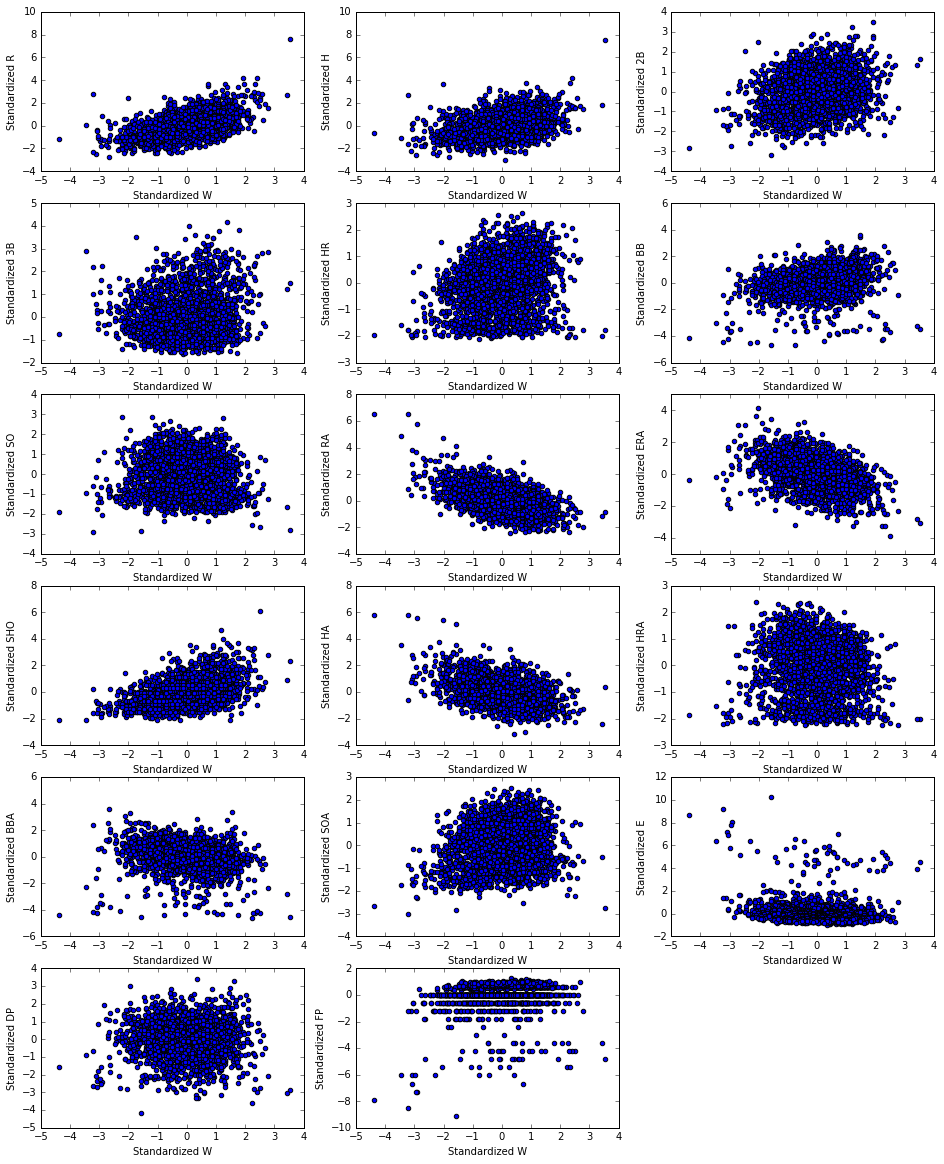

In [18]:
n = len(features)

fig = figure(figsize = (16,20))
subplots_adjust(wspace = 0.2, hspace = 0.2)
iplot = 0
for i in range(n):
    iplot += 1
    ax = fig.add_subplot(6,3,iplot)
    ax.scatter(df_std[response], df_std[features[i]])
    ax.set_ylabel('Standardized ' + features[i])
    ax.set_xlabel('Standardized W')

### We can see that some of the features are more closely related to the response from their plot<BR> (R vs W, RA vs W, ...)
---
### Before building a model, we will shuffle the data and split it into train and test.
* For a shuffle, first, we create a vector with uniformaly distributed numbers between 0 and 1
* Then, we take a vector with the length as the same number of rows from our data frame and transfer it to pandas data frame.
* We use it to do 80:20 split on our data.

In [19]:
np.random.seed(seed = 1234)
random_idx = np.random.rand(df.shape[0])

In [20]:
pd.DataFrame(random_idx).describe()

,0
count,2368.000000
mean,0.500256
std,0.294930
min,0.000227
25%,0.236542
50%,0.507068
75%,0.760850
max,0.999964


In [21]:
df_train = df_std[ random_idx <  0.8 ]
df_test  = df_std[ random_idx >= 0.8 ]

print 'number of records in df_std   : ' + str( df_std.shape[0])
print 'number of records in df_train : ' + str( df_train.shape[0])
print 'number of records in df_test  : ' + str( df_test.shape[0])

number of records in df_std   : 2368
number of records in df_train : 1870
number of records in df_test  : 498


We build the regression models.
---
Four different methods will be used. We first build the **ordinary least squares** model with train data.    
And check the performance of the model on test set by looking at its mean squared error and R2 score.

In [22]:
regr = linear_model.LinearRegression()
regr.fit(df_train[features], df_train[response])

ols_mse = metrics.mean_squared_error(regr.predict(df_test[features]), df_test[response])
ols_r2  = metrics.r2_score(regr.predict(df_test[features]), df_test[response])

print 'mean squared error :', ols_mse
print 'R2 score           :', ols_r2

mean squared error : 0.107839824585
R2 score           : 0.884473462041


### Let's store the scores so that we can compare them with the scores of other models  later.

In [23]:
pd_index = []
pd_mse   = []
pd_r2    = []

pd_index.append('Ordinary Least Squares')
pd_mse.append(round(ols_mse,6))
pd_r2.append(round(ols_r2,6))

Now, we store the coefficients values for the features.
---
* retrieve the coefficients from the model.
* sort them in absolute values since we are comparing the magnitudes.
* visualize with bar graphs.

In [24]:
coeffs_df = pd.DataFrame(regr.coef_, index = features, columns = ['feature'])
coeffs_df['feature_abs'] = coeffs_df.abs()
coeffs_df = coeffs_df.sort_values(by = 'feature_abs', ascending = False)

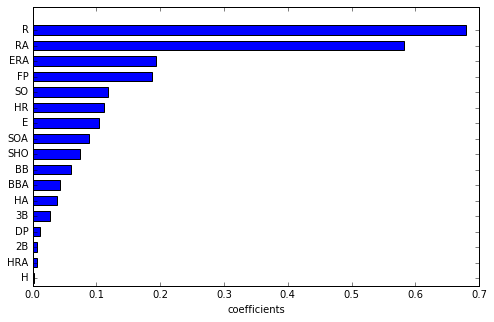

In [25]:
plt.figure(figsize = (8,5))
pos = arange(coeffs_df.shape[0], 0, -1) - 0.5
plt.barh(pos, coeffs_df['feature_abs'].values, height = 0.6,  align = 'center')
plt.yticks(pos, coeffs_df['feature_abs'].index)
plt.xlabel('coefficients')
plt.show()

### Forward stepwise selection to reduce the number of features
* start the model with a random feature 
* choose the best one and add one feature per each step until the best result
* use 5-fold cross-validation by mean squared error for scoring

In [26]:
full_features    = list(coeffs_df.index)

features_list    = []
mse_list         = []
forward_features = []

temp_regr = linear_model.LinearRegression()

for idx_feature in range(len(features)):
    if idx_feature == 0:
        tmp_features_list = []
        tmp_mse_list      = []
        for feature in features:
            temp_regr.fit(df_train[[feature]],df_train[response])
        
            params_cross_val    = {'estimator':temp_regr,'X':df_train[[feature]],
                                   'y':df_train[response],'scoring':'mean_squared_error','cv':5}
            mean_squared_errors = cross_validation.cross_val_score(**params_cross_val)
            mse_mean            = mean_squared_errors.mean()
            tmp_mse_list.append(mse_mean)
       
        best_mse = tmp_mse_list[0]
        for idx, mse in enumerate(tmp_mse_list):
            if mse >= best_mse:
                best_mse      = mse
                added_feature = features[idx]
        features_list.append([added_feature])
        mse_list.append(best_mse)
        
    else:
        forward_features.append(added_feature)
        full_features.remove(added_feature)
        tmp_features_list = []
        tmp_mse_list      = []        
       
        for feature in full_features:
            temp_regr.fit(df_train[forward_features + [feature]],df_train[response])
        
            params_cross_val    = {'estimator':temp_regr,'X':df_train[forward_features+[feature]],
                                   'y':df_train[response],'scoring':'mean_squared_error','cv': 5}
            mean_squared_errors = cross_validation.cross_val_score(**params_cross_val)
            mse_mean            = mean_squared_errors.mean()
            tmp_mse_list.append(mse_mean)
            
        best_mse = tmp_mse_list[0]
        for idx, mse in enumerate(tmp_mse_list):
            if mse >= best_mse:
                best_mse      = mse
                added_feature = full_features[idx]
        features_list.append(forward_features + [added_feature])
        mse_list.append(best_mse)
        
best_mse = mse_list[0]
for idx, mse in enumerate(mse_list):
    if mse >= best_mse:
        best_mse         = mse
        forward_features = features_list[idx]
        
print 'full features sorted by coeff.', list(coeffs_df.index)
print 'optimal subset of features are', forward_features
print (len(features) - len(forward_features)), 'features are removed'

full features sorted by coeff. ['R', 'RA', 'ERA', 'FP', 'SO', 'HR', 'E', 'SOA', 'SHO', 'BB', 'BBA', 'HA', '3B', 'DP', '2B', 'HRA', 'H']
optimal subset of features are ['RA', 'R', 'SHO', 'HR', 'ERA', 'FP', 'BB', 'BBA', 'SO', 'SOA']
7 features are removed


### As we can see from above, most of the features removed have smaller coefficients.   
### We rebuild a model with the selected features and store the scores.

In [27]:
temp_regr.fit(df_train[forward_features], df_train[response])
forward_mse = metrics.mean_squared_error(temp_regr.predict(df_test[forward_features]), 
                                         df_test[response])
forward_r2  = metrics.r2_score(temp_regr.predict(df_test[forward_features]), df_test[response])

print 'mean squared error :', forward_mse
print 'R2 score           :', forward_r2

pd_index.append('Forward Features')
pd_mse.append(round(forward_mse,6))
pd_r2.append(round(forward_r2,6))

mean squared error : 0.107726178126
R2 score           : 0.884515897645


### Ridge Regression
Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients.<BR> The ridge coefficients minimize a penalized residual sum of squares. We need to determine the value of lambda, a complexity <BR>parameter that controls the amount of shrinkage, by cross-validation.

In [28]:
lambda_ = linear_model.RidgeCV(cv = 5)
lambda_.fit(df_train[features],df_train[response])    

ridge_lambda = lambda_.alpha_
print ridge_lambda

10.0


In [29]:
ridge_regr = linear_model.Ridge(alpha = ridge_lambda)
ridge_regr.fit(df_train[features],df_train[response])
ridge_mse  = metrics.mean_squared_error(ridge_regr.predict(df_test[features]), df_test[response])
ridge_r2   = metrics.r2_score(ridge_regr.predict(df_test[features]), df_test[response])

print 'mean squared error :',ridge_mse
print 'R2 score           :', ridge_r2

pd_index.append('Ridge Regression')
pd_mse.append(round(ridge_mse,6))
pd_r2.append(round(ridge_r2,6))

mean squared error : 0.108192200686
R2 score           : 0.883300950907


### Lasso Regression
The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions <BR>with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. We also <BR>need lambda value for Lasso.

In [30]:
lambda_ = linear_model.LassoCV(cv = 5)
lambda_.fit(df_train[features],df_train[response])    

lasso_lambda = lambda_.alpha_
print lasso_lambda

0.0032680223849


In [31]:
lasso_regr = linear_model.Lasso(alpha = lasso_lambda)
lasso_regr.fit(df_train[features], df_train[response])
lasso_mse  = metrics.mean_squared_error(lasso_regr.predict(df_test[features]), df_test[response])
lasso_r2   = metrics.r2_score(lasso_regr.predict(df_test[features]), df_test[response])

print 'mean squared error :',lasso_mse
print 'R2 score           :', lasso_r2

pd_index.append('Lasso Regression')
pd_mse.append(round(lasso_mse,6))
pd_r2.append(round(lasso_r2,6))

mean squared error : 0.107399869848
R2 score           : 0.882948000563


### Let's look at the scores of all four models.

In [32]:
pd_dict                       = {}
pd_dict['Mean Squared Error'] = pd_mse
pd_dict['R2 Score']           = pd_r2
comparison_table              = pd.DataFrame(pd_dict,index=pd_index, columns=list(pd_dict.keys()))

comparison_table

,Mean Squared Error,R2 Score
Ordinary Least Squares,0.107840,0.884473
Forward Features,0.107726,0.884516
Ridge Regression,0.108192,0.883301
Lasso Regression,0.107400,0.882948


#### Lasso regression model has the smallest mean squared error and "forward features" model has the best r2 score, but not by much.
<BR>

### Let's rebuild the ordinary least squares model on unstandardized data to see the actual values of error.

In [33]:
df_train = df[ random_idx <  0.8 ]
df_test  = df[ random_idx >= 0.8 ]

In [34]:
regr = linear_model.LinearRegression()
regr.fit(df_train[features], df_train[response])
compare_df = df_test.copy()
compare_df['Prediction'] = regr.predict(df_test[features])
compare_df.loc[:200,['Prediction', response]]

,Prediction,W
57,0.741756,0.703125
58,0.713576,0.688525
59,0.472149,0.433333
69,0.527025,0.532258
74,0.516662,0.530864
80,0.711606,0.779070
82,0.298010,0.253012
87,0.424866,0.457831
89,0.456820,0.423529
105,0.383048,0.462500


* The model's predictions are pretty close to the actual values.
* We can conclude that the coefficients of each stats/features from the model are reliable.
* The list of 17 stats ordered by "importance" from the most to the least is the following.

In [35]:
print list(coeffs_df.index)

['R', 'RA', 'ERA', 'FP', 'SO', 'HR', 'E', 'SOA', 'SHO', 'BB', 'BBA', 'HA', '3B', 'DP', '2B', 'HRA', 'H']
